<a href="https://colab.research.google.com/github/vitroid/TileCycles/blob/main/TileCycles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparations to run it on Google Colaboratory

In [1]:
# Obtain the source tree and install from that
! mkdir github; cd github && git clone https://github.com/vitroid/TileCycles.git
! cd github/TileCycles; make install

# install genice to generate the structure of ice.
! pip install genice2


mkdir: cannot create directory ‘github’: File exists
fatal: destination path 'TileCycles' already exists and is not an empty directory.
python setup.py install
running install
running bdist_egg
running egg_info
writing TileCycles.egg-info/PKG-INFO
writing dependency_links to TileCycles.egg-info/dependency_links.txt
writing requirements to TileCycles.egg-info/requires.txt
writing top-level names to TileCycles.egg-info/top_level.txt
writing manifest file 'TileCycles.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
running build_ext
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/tilecycles
copying build/lib.linux-x86_64-3.7/tilecycles/Buch.py -> build/bdist.linux-x86_64/egg/tilecycles
copying build/lib.linux-x86_64-3.7/tilecycles/Dipole.py -> build/bdist.linux-x86_64/egg/tilecycles
copying build/lib.linux-x86_64-3.7/tilecycles/__init__.py -> build/bdist.linux-x86_64/egg/tilecycles
copying build/

In [20]:
# in case the repository is updated.
! cd github/TileCycles; git pull
! cd github/TileCycles; make clean uninstall install
exit()

Already up to date.
rm  *.so *~ */*~ *.o *.gro *.rdf
rm: cannot remove '*.so': No such file or directory
rm: cannot remove '*~': No such file or directory
rm: cannot remove '*/*~': No such file or directory
rm: cannot remove '*.o': No such file or directory
rm: cannot remove '*.gro': No such file or directory
rm: cannot remove '*.rdf': No such file or directory
Makefile:43: recipe for target 'clean' failed
make: [clean] Error 1 (ignored)
rm -rf build dist *.egg-info
# -rm -rf PairList.egg-info
pip uninstall -y tilecycles
Uninstalling TileCycles-0.1.5.2:
  Successfully uninstalled TileCycles-0.1.5.2
python setup.py install
running install
running bdist_egg
running egg_info
creating TileCycles.egg-info
writing TileCycles.egg-info/PKG-INFO
writing dependency_links to TileCycles.egg-info/dependency_links.txt
writing requirements to TileCycles.egg-info/requires.txt
writing top-level names to TileCycles.egg-info/top_level.txt
writing manifest file 'TileCycles.egg-info/SOURCES.txt'
writing ma

# Benchmark tests

In [1]:
from genice2.genice import GenIce
from genice2.plugin import Lattice, Format, Molecule

import networkx as nx
import numpy as np
import random
import time


# sampling parameters for benchmarking
# Accurate
maxRepeat = 100  # loops
maxAccum  = 25   # sec
maxProc   = 100  # sec
maxNode   = 1000000

# Rough estimate
maxRepeat = 10  # loops
maxAccum  = 5   # sec
maxProc   = 10  # sec
maxNode   = 100000

# test for perfect ices
def test_icerule(d, N):
    assert d.number_of_nodes() == N
    for node in d:
        assert d.in_degree(node) == 2
        assert d.in_degree(node) == 2   

## Buch's algorithm

There are two hydrogen sites between two neighboring oxygens, and Buch's algorithm assumes that the initial configuration is one in which all the hydrogens randomly occupy one of the two sites.

In the initial configuration, there are many oxygen atoms with excess hydrogen. The algorithm migrates hydrogen from such an oxygen atom to a neighboring oxygen atom, and repeats the process randomly until there are two hydrogen species in every oxygen atom.


In [3]:
import tilecycles.Buch as Buch


lattice = Lattice("1c")
formatter = Format("raw", stage=(2,))  # generates an undirected graph

time_buch_icerule = []
lastN = 0
for NN in range(8, 100):
    N = int(1.4**(NN/3))
    if N == lastN:
        continue
    lastN = N
    raw = GenIce(lattice, rep=[N, N, N]).generate_ice(formatter)
    g = raw['graph']
    Nnode = g.number_of_nodes()

    delta = 0.0
    Nrep = 0
    while delta < maxAccum and Nrep < maxRepeat:
        dd = nx.DiGraph()
        for a, b in g.edges():
            if random.randint(0, 1) == 1:
                dd.add_edge(a, b)
            else:
                dd.add_edge(b, a)

        now = time.time()
        Buch.migrate(dd, set([x for x in dd.nodes if dd.out_degree(x) > 2]))
        delta += time.time() - now
        Nrep += 1
    delta /= Nrep
    time_buch_icerule.append([Nnode, delta, Nrep])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    test_icerule(dd, Nnode)
    if delta > maxProc:
        break
    if Nnode > maxNode:
        break

64 molecules 0.0037578582763671876 s avg. 10 reps.
216 molecules 0.015002584457397461 s avg. 10 reps.
512 molecules 0.03644030094146729 s avg. 10 reps.
1000 molecules 0.09190850257873535 s avg. 10 reps.
1728 molecules 0.14869184494018556 s avg. 10 reps.
2744 molecules 0.2798877239227295 s avg. 10 reps.
4096 molecules 0.6572456061840057 s avg. 8 reps.
5832 molecules 0.8535568373543876 s avg. 7 reps.
8000 molecules 1.3885011672973633 s avg. 4 reps.
10648 molecules 1.6809146404266357 s avg. 3 reps.
17576 molecules 12.423659801483154 s avg. 1 reps.


## (GenIce algorithm)

The code to measure the processing time including the depolarization is in the next Section.

## Rahman's algorithm

The algorithm prepares a depolarized structure in advance and generates a hydrogen-disordered structure by successively reversing randomly chosen homodromic cycles.

Here, the ice Ic structure generated by GenIce is used as an initial structure, and the procedure is repeated until all the edges are inverted at least once.

In [4]:
import tilecycles.Rahman as Rahman

lattice = Lattice("1c")
formatter = Format("raw", stage=(3,))  # We need the directed graph of ice!

time_rahman_icerule = []
for N in range(1, 20):
    raw = GenIce(lattice, rep=[N, N, N]).generate_ice(formatter)
    d = nx.DiGraph(raw['digraph'].edges())
    Nnode = d.number_of_nodes()

    delta = 0.0
    Nrep = 0
    while delta < maxAccum and Nrep < maxRepeat:
        # footprint
        g = nx.Graph(d)

        now = time.time()
        while g.number_of_edges() > 0:
            cycle = Rahman.six(d, d.number_of_nodes())
            Rahman.invertCycle(d, cycle, g)
        delta += time.time() - now
        Nrep += 1
    delta /= Nrep
    time_rahman_icerule.append([Nnode, delta, Nrep])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    test_icerule(d, Nnode)
    if delta > maxProc:
        break

8 molecules 0.0027656078338623045 s avg. 10 reps.
64 molecules 0.023506903648376466 s avg. 10 reps.
216 molecules 0.09674634933471679 s avg. 10 reps.
512 molecules 0.35381035804748534 s avg. 10 reps.
1000 molecules 1.0022691249847413 s avg. 5 reps.
1728 molecules 2.6800748109817505 s avg. 2 reps.
2744 molecules 5.724560737609863 s avg. 1 reps.
4096 molecules 14.762807846069336 s avg. 1 reps.


# With depolarization




## Buch's algorithm

We implement the efficient algorithm to depolarize the HB network of ice which was developed for GenIce.

In [ ]:
import tilecycles.Buch as Buch
import tilecycles.Dipole as dp

lattice = Lattice("1c")
formatter = Format("raw", stage=(1,2,))  # generates an undirected graph

N=8
raw = GenIce(lattice, rep=[N, N, N]).generate_ice(formatter)
g = raw['graph']
Nnode = g.number_of_nodes()

Nrep = 10
time_buch_icerule = []
time_buch_depol = []

for loop in range(Nrep):
    dd = nx.DiGraph()
    for a, b in g.edges():
        if random.randint(0, 1) == 1:
            dd.add_edge(a, b)
        else:
            dd.add_edge(b, a)

    now = time.time()
    Buch.migrate(dd, set([x for x in dd.nodes if dd.out_degree(x) > 2]))
    delta = time.time() - now
    time_buch_icerule.append(delta)
    
    test_icerule(dd, Nnode)

    rpos = raw['reppositions']
    cell = raw['repcell']

    dipoles = dict()
    # make relative vectors
    for a, b in dd.edges():
        dr = rpos[b] - rpos[a]
        dr -= np.floor(dr+0.5)
        dipoles[a, b] = dr

    now = time.time()
    dp.force_depolarize(dd, rpos, cell, dipoles)
    delta = time.time() - now
    time_buch_depol.append(delta)

    net = dp.net_polarization(dipoles)
    print(net)

print(np.mean(time_buch_icerule))
print(np.mean(time_buch_depol))

[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
0.1745654821395874
0.15979175567626952


## Rahman's algorithm

In Rahman's algorithm, the initial structure should be already depolarized. To avoid additional polarizations, a traversing cycle must be excluded in the process of shuffling the network, and that costs additionally.

In [ ]:
import tilecycles.Rahman as Rahman


lattice = Lattice("1c")
formatter = Format("raw", stage=(3,))  # We need the directed graph of ice!

N = 8
raw = GenIce(lattice, rep=[N, N, N]).generate_ice(formatter)
d = nx.DiGraph(raw['digraph'].edges())
Nnode = d.number_of_nodes()

Nrep = 2

time_rahman_withdepol = []
for loop in range(Nrep):
    # footprint
    g = nx.Graph(d)

    now = time.time()
    while g.number_of_edges() > 0:
        cycle = Rahman.six(d, d.number_of_nodes())
        Rahman.invertCycle(d, cycle, g)
    delta = time.time() - now
    print(delta)
    time_rahman_withdepol.append(delta)
    test_icerule(d, Nnode)

time_rahman_icerule = []
for loop in range(Nrep):
    # footprint
    g = nx.Graph(d)

    # Shortest size of the traversing cycle
    Ntra = N*4

    now = time.time()
    while g.number_of_edges() > 0:
        cycle = Rahman.six(d, d.number_of_nodes(), Ntra)
        Rahman.invertCycle(d, cycle, g)
    delta = time.time() - now
    print(delta)
    time_rahman_icerule.append(delta)

    test_icerule(d, Nnode)

print(np.mean(time_rahman_withdepol))
print(np.mean(time_rahman_icerule))

4.366569995880127
4.8850109577178955
6.503124952316284
7.61551308631897
4.625790476799011
7.059319019317627


## GenIce algorithm

In [5]:
import tilecycles.Dipole as dp
import tilecycles as tc

lattice = Lattice("1c")
formatter = Format("raw", stage=(1,2,))  # generates an undirected graph

time_genice_icerule = []
time_genice_depol = []
for NN in range(4, 100):
    N = int(2**(NN/3))
    raw = GenIce(lattice, rep=[N, N, N]).generate_ice(formatter)
    g0 = raw['graph']
    rpos = raw['reppositions']
    cell = raw['repcell']
    Nnode = g0.number_of_nodes()

    Nrep = 0
    time_icerule = 0
    time_depol = 0
    Nfb = 0
    delta = 0
    while time_icerule < maxAccum and Nrep < maxRepeat:
        g = nx.Graph(g0)

        now = time.time()
        dd = nx.DiGraph()
        cycles = []
        for cycle in tc.tileByCycles(g):
            nx.add_cycle(dd, cycle)
            cycles.append(cycle)
        delta = time.time() - now
        time_icerule += delta

        test_icerule(dd, Nnode)

        dipoles = dict()
        # make relative vectors
        for a, b in dd.edges():
            dr = rpos[b] - rpos[a]
            dr -= np.floor(dr+0.5)
            dipoles[a, b] = dr

        now = time.time()
        fallback = tc.depolarize(cycles, dipoles, dd, rpos, cell)
        Nfb += fallback
        delta = time.time() - now
        time_depol += delta

        net = dp.net_polarization(dipoles)
        assert np.allclose(net, 0)
        
        Nrep += 1
    time_icerule /= Nrep
    time_depol /= Nrep
    time_genice_icerule.append([Nnode, time_icerule, Nrep])
    time_genice_depol.append([Nnode, time_depol, Nrep, Nfb])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    if Nnode >= maxNode:
        break

give up depolarizing completely.
Original GenIce algorithm.
give up depolarizing completely.
Original GenIce algorithm.
give up depolarizing completely.
Original GenIce algorithm.
64 molecules 0.0013778209686279297 s avg. 10 reps.
give up depolarizing completely.
Original GenIce algorithm.
give up depolarizing completely.
Original GenIce algorithm.
216 molecules 0.0024492740631103516 s avg. 10 reps.
512 molecules 0.005668163299560547 s avg. 10 reps.
1000 molecules 0.01037454605102539 s avg. 10 reps.
1728 molecules 0.0184476375579834 s avg. 10 reps.
4096 molecules 0.04131770133972168 s avg. 10 reps.
8000 molecules 0.0954582691192627 s avg. 10 reps.
13824 molecules 0.1549055576324463 s avg. 10 reps.
32768 molecules 0.35439133644104004 s avg. 5 reps.
64000 molecules 0.6922118663787842 s avg. 3 reps.
125000 molecules 1.349839687347412 s avg. 2 reps.


In [6]:
time_genice_icerule, time_genice_depol

([[64, 0.005505919456481934, 10],
  [216, 0.006479120254516602, 10],
  [512, 0.014496946334838867, 10],
  [1000, 0.025208520889282226, 10],
  [1728, 0.04537687301635742, 10],
  [4096, 0.11452908515930176, 10],
  [8000, 0.23430793285369872, 10],
  [13824, 0.44858479499816895, 10],
  [32768, 1.1215882778167725, 5],
  [64000, 2.3681859970092773, 3],
  [125000, 4.803917407989502, 2]],
 [[64, 0.0045849323272705075, 10, 3],
  [216, 0.006995058059692383, 10, 2],
  [512, 0.006499004364013672, 10, 0],
  [1000, 0.011461901664733886, 10, 0],
  [1728, 0.018102097511291503, 10, 0],
  [4096, 0.043877482414245605, 10, 0],
  [8000, 0.08519117832183838, 10, 0],
  [13824, 0.1531261682510376, 10, 0],
  [32768, 0.35542807579040525, 5, 0],
  [64000, 0.6842133204142252, 3, 0],
  [125000, 1.3648793697357178, 2, 0]])

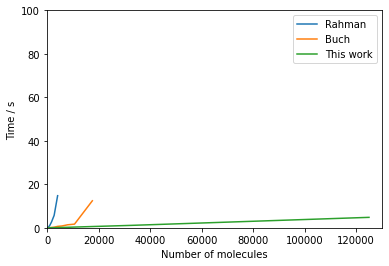

In [8]:
from matplotlib import pyplot as plt


time_buch_icerule = np.array(time_buch_icerule)
time_genice_icerule = np.array(time_genice_icerule)
time_rahman_icerule = np.array(time_rahman_icerule)


fig1, ax = plt.subplots()

# ax.set_aspect('square') #, adjustable='box')

plt.plot(time_rahman_icerule[:, 0], time_rahman_icerule[:, 1], label="Rahman")
plt.plot(time_buch_icerule[:, 0], time_buch_icerule[:, 1], label="Buch")
plt.plot(time_genice_icerule[:, 0], time_genice_icerule[:, 1], label="This work")
plt.xlim(0, 130000)
plt.legend()
plt.xlabel("Number of molecules")
plt.ylabel("Time / s")
plt.ylim(0, 100)
plt.show()

# fig1.savefig("benchmark.pdf")

Text(0, 0.5, 'Time / s')

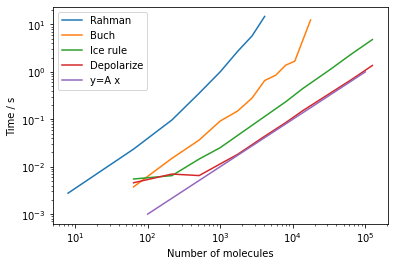

In [9]:
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

time_genice_icerule = np.array(time_genice_icerule)
time_genice_depol = np.array(time_genice_depol)

fig1, ax = plt.subplots()

lin = np.linspace(1e2, 1e5, 100)
plt.loglog(time_rahman_icerule[:, 0], time_rahman_icerule[:, 1], label="Rahman")
plt.loglog(time_buch_icerule[:, 0], time_buch_icerule[:, 1], label="Buch")
plt.loglog(time_genice_icerule[:, 0], time_genice_icerule[:, 1], label="Ice rule")
plt.loglog(time_genice_depol[:, 0], time_genice_depol[:, 1], label="Depolarize")

plt.loglog(lin, lin*1e-5, label=r"y=A x")
plt.legend()
plt.xlabel("Number of molecules")
plt.ylabel("Time / s")

# fig1.savefig("benchmark-dep-loglog.pdf")



# With defects

If the ice includes defects, i.e., if the graph is not an even graph, it is impossible to tile with cycles only. However, it is still possible to tile it with cycles and some chains connecting the vertices of the odd degree. 

In the following algorithm, first we look up the shortest chains connecting odd vertices by Dijkstra algorithm, remove them from the undirected graph, and then we tile the graph with cycles.


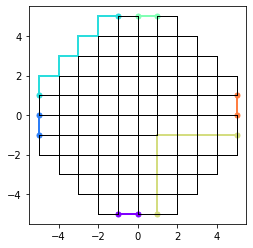

In [3]:
# Visualize the odd-odd chains

import numpy as np
import networkx as nx
import random

from matplotlib import pyplot as plt
import tilecycles as tc
import tilecycles.Dipole as dp


def draw_edge(edge, pos, threshold, color, linewidth=1):
    a, b = edge
    va = pos[a]
    vb = pos[b]
    d = vb - va
    if d@d > threshold:
        d -= np.floor(d+0.5)
        seg = np.vstack([vb-d, vb])
        plt.plot(seg[:, 0], seg[:, 1], color=color, linewidth=linewidth)
    seg = np.vstack([va, va+d])
    plt.plot(seg[:, 0], seg[:, 1], color=color, linewidth=linewidth)


def draw_markers(a, pos, color):
    va = pos[a, :]
    plt.plot(va[:, 0], va[:, 1], 'o', color=color, markersize=5)


def draw_cycle(cycle, pos, threshold, color):
    for i in range(len(cycle)):
        a = cycle[i-1]
        b = cycle[i]
        draw_edge((a,b), pos, threshold, color)


def draw_path(path, pos, threshold, color):
    for i in range(len(path)-1):
        a = path[i]
        b = path[i+1]
        draw_edge((a,b), pos, threshold, color, linewidth=2)
    draw_markers((path[0], path[-1]), pos, color)


R = 5
pos = []
for x in range(-R, R+1):
    for y in range(-R, R+1):
        if (R+0.5)**2 > x**2 + y**2:
            pos.append([x,y])

pos = np.array(pos)
g = nx.Graph()
N = len(pos)
for a in range(N):
    for b in range(a):
        d = pos[a] - pos[b]
        if d@d < 1.1:
            g.add_edge(a, b)

fig1, ax = plt.subplots()

dd = nx.DiGraph()

# orientations of the chains may be changed later in order to reduce the polarization

cm = plt.get_cmap('rainbow')

# remove the chains from the graph.
oochains = [path for path in tc.odd_chains(g)]
for i, path in enumerate(oochains):
    tc.remove_path(g, path)
    nx.add_path(dd, path)
    col = i / len(oochains)
    draw_path(path, pos, 999999, cm(col))


cycles = []
for cycle in tc.tileByCycles(g, N):
    cycles.append(cycle)
    draw_cycle(cycle, pos, 999999, (0,0,0))


ax.set_aspect('equal', adjustable='box')
plt.show()
fig1.savefig("surface.pdf", bbox='tight')

# Validation

生成した氷の構造が十分にランダムであるかどうかを確認するために、サイクルを構成する水素結合の向きの統計をとる。

氷の結晶構造はさまざまなサイズのirreducible ringsで構成されている。氷Iは6員環のみで構成されている。アイスルールを満たすネットワークに含まれる1つの6員環に注目すると、それを構成する水素結合の配向パターンには統計的な特徴がある。ここでは計算を簡単にするために次のようなBethe tree 近似を導入する。ある4-connectedな無限無向グラフ$g$が、6-cycleを1つだけもち、ほかにはサイクルを持たないものとする。このグラフ$g$にアイスルールを導入して有向グラフに変換した時、6-cycleに沿った辺の配向パターンの分布は表1のようになる。(誰かすでにやってそうなものだ。Stillinger?)

*Table 1 アイスルールを満たす有向グラフの六員環の配向パターンと、Bethe tree近似による出現確率*

| pattern| probability|
|------|--------|
|→→→→→→| 64/365 |
|→→→→→←| 96/365 |
|→→→→←←| 96/365 |
|→→→←→←| 24/365 |
|→→→←←←| 48/365 |
|→→←→→←| 12/365 |
|→→←→←←| 24/365 |
|→←→←→←|  1/365 |

現実の氷には無数の六員環が含まれているが、均質にランダムな水素無秩序氷では、上の分布に極めて近い分布が得られる。そこで、表1の分布と、生成した氷構造での配向パターンの分布を比較し、それらの分布の間のKullback-Leibler divergence $d_{KL}$を、氷構造の均質さの尺度とみなす。均質にランダムな水素無秩序氷では、$d_{KL}$は0に近付くが、配向パターンに偏りがあると、より大きな値になる。

Rahmanらのアルゴリズムと、Buchらのアルゴリズムはどちらも収束的なアルゴリズムで、計算サイクルを増やすほど均質な分布に近付く。Rahmanらのアルゴリズムに関しては、初期配置を氷XI構造とする。また、Buchのアルゴリズムでは、初期配置はice ruleを満たさない完全ランダムな有向グラフとする。そして、ステップを重ねるごとに、上の分布にどのように近接するかを観察する。


# Validation

To check whether the structure of the generated ice is sufficiently random, we take the statistics of the orientation of the hydrogen bonds that make up the cycle.

The crystal structure of ice consists of irreducible rings of various sizes. Ice I consists of only six-membered rings. If we focus on a single six-membered ring in the network that satisfies the ice rules, the orientation pattern of the hydrogen bonds that make up the ring has a statistical characteristic. To simplify the calculation, we introduce the following Bethe tree approximation. Suppose that a 4-connected infinite undirected graph $g$ has only one 6-cycle and no other cycles. When this graph $g$ is transformed into a directed graph by introducing the ice rules, the distribution of  edge orientation patterns along the 6-cycle is as shown in Table 1.

*Table 1 Orientation patterns of six-membered rings in directed graphs satisfying the ice rules and their probability of occurrence using the Bethe tree approximation*.

| pattern| probability|
|------|--------|
|→→→→→→| 64/365 |
|→→→→→←| 96/365 |
|→→→→←←| 96/365 |
|→→→←→←| 24/365 |
|→→→←←←| 48/365 |
|→→←→→←| 12/365 |
|→→←→←←| 24/365 |
|→←→←→←|  1/365 |

Although real ice contains innumerable six-membered rings, homogeneously random hydrogen-disordered ice yields a distribution very close to the above one. Therefore, we compare the distributions in Table 1 with the distributions of the orientation patterns in the generated ice structure, and consider the Kullback-Leibler divergence $d_{KL}$ between these distributions as a measure of the homogeneity of the ice structure. For homogeneously random hydrogen-disordered ice, $d_{KL}$ approaches zero, while biases in the orientation pattern lead to larger values.

Both Rahman et al.'s and Buch et al.'s algorithms are convergent algorithms, approaching a homogeneous distribution with increasing number of computational cycles. For Rahman et al.'s algorithm, we choose the ice XI structure as the initial configuration. For Buch's algorithm, the initial configuration is a completely random directed graph that does not satisfy the ice rules. Then, with each step, we observe how it approaches the distribution above.

In [11]:
# Taken from GenIce/_ringstat.py
from genice2.formats._ringstat import probabilities, orientations, encode
from collections import defaultdict
from cycless.cycles import cycles_iter
import networkx as nx
from math import log


def KLdiv(d, pos):
    graph = nx.Graph(d)  # undirected
    prob = probabilities(6)
    stat = defaultdict(int)

    for ring in cycles_iter(graph, 6,  pos=pos):
        ori = orientations(ring, d)
        c   = encode(ori)
        n   = len(ring)
        stat[c] += 1

    #size code code(binary) Approx. Stat.
    denom = 0
    for c in stat:
        denom += stat[c]
    dKL = 0.0
    for c in prob:
        q = stat[c]/denom
        p = prob[c]
        if q > 0.0:
            dKL += q*(log(q) - log(p))
    dKL /= log(2.0)  #bit
    return dKL

In [12]:
# Rahman's
import tilecycles.Rahman as Rahman

lattice = Lattice("11")
formatter = Format("raw", stage=(1,3,))

N = 8
raw = GenIce(lattice, rep=[N, N, N]).generate_ice(formatter)
d = nx.DiGraph(raw['digraph'].edges())
Nnode = d.number_of_nodes()
rpos = raw['reppositions']

# footprint
g = nx.Graph(d)

steps = 0
watch = 1
rahman_conv = []
while g.number_of_edges() > 0:
    steps += 1
    if watch == steps:
        # ring stat
        dKL = KLdiv(d, rpos)
        print(steps, dKL)
        rahman_conv.append([steps, dKL])
        # next watch interval
        watch += 100  # watch

    cycle = Rahman.six(d, d.number_of_nodes())
    Rahman.invertCycle(d, cycle, g)

dKL = KLdiv(d, rpos)
print(steps, dKL)
rahman_conv.append([steps, dKL])


1 0.8230307782265128
101 0.46683523667930915
201 0.2870459895577991
301 0.16959492265426093
401 0.120607158643624
501 0.0863366204624626
601 0.05969701766662183


KeyboardInterrupt: ignored

In [ ]:
# Buch's
import tilecycles.Buch as Buch


buch_conv = []

def migrate2(d, excess):
    """
    excess is a set of nodes having more than two outgoing edges
    """
    steps = 0
    watch = 1
    while len(excess) > 0:
        steps += 1
        if watch <= steps:
            # ring stat
            dKL = KLdiv(d, rpos)
            print(steps, dKL)
            buch_conv.append([steps, dKL])
            # next watch interval
            watch += 1000  # watch / 2

        head = random.choice(list(excess))
        nexts = list(d.successors(head))
        next = random.choice(nexts)
        d.remove_edge(head, next)
        d.add_edge(next, head)
        # if head's outgoing order was three
        if len(nexts) == 3:
            # remove from the excess list
            excess.remove(head)
        # if next's outgoing orderis three
        if d.out_degree(next) == 3:
            # it becomes a new excess
            excess.add(next)
    dKL = KLdiv(d, rpos)
    print(steps, dKL)
    buch_conv.append([steps, dKL])


lattice = Lattice("1h")
formatter = Format("raw", stage=(1,2,))  # generates an undirected graph


N = 8
raw = GenIce(lattice, rep=[N, N, N]).generate_ice(formatter)
g = raw['graph']
rpos = raw['reppositions']
Nnode = g.number_of_nodes()

dd = nx.DiGraph()
for a, b in g.edges():
    if random.randint(0, 1) == 1:
        dd.add_edge(a, b)
    else:
        dd.add_edge(b, a)

migrate2(dd, set([x for x in dd.nodes if dd.out_degree(x) > 2]))


In [ ]:
# GenIce's
import tilecycles as tc

lattice = Lattice("1h")
formatter = Format("raw", stage=(1,2,))  # generates an undirected graph

N=8
raw = GenIce(lattice, rep=[N, N, N]).generate_ice(formatter)
g = nx.Graph(raw['graph'])
rpos = raw['reppositions']

d = nx.DiGraph()
for cycle in tc.tileByCycles(g):
    nx.add_cycle(d, cycle)

genice_dKL = KLdiv(d, rpos)
print(genice_dKL)


0.0005141507548805231


In [ ]:
from matplotlib import pyplot as plt


buch_conv = np.array(buch_conv)
rahman_conv = np.array(rahman_conv)

fig1, ax = plt.subplots()

lin = np.linspace(1e2, 1e5, 100)
plt.plot(rahman_conv[:, 0] / rahman_conv[-1, 0]*100, rahman_conv[:, 1], label="Rahman")
plt.plot(buch_conv[:, 0] / buch_conv[-1, 0]*100, buch_conv[:, 1], label="Buch")
plt.plot(100, genice_dKL, 'o', label="This work")
plt.yscale('log')
plt.legend()
plt.xlabel("Progress (%)")
plt.ylabel(r"$d_\mathrm{KL}$")

fig1.savefig("ringstat-log.pdf")

# Comparison with C++ code

In [13]:
# C++ implementation

import tilecycles_c as ctc
import numpy as np

lattice = Lattice("1c")
formatter = Format("raw", stage=(2,))  # generates an undirected graph

seed = 1111

time_cpp_icerule = []
for NN in range(4, 100):
    N = int(2**(NN/3))
    raw = GenIce(lattice, rep=[N, N, N]).generate_ice(formatter)
    g0 = raw['graph']
    Nnode = g0.number_of_nodes()

    pairs = np.array([(i, j) for i, j in g0.edges()], dtype=np.int32)

    delta = 0.0
    Nrep = 0
    while delta < maxAccum and Nrep < maxRepeat:
        now = time.time()
        dd = nx.DiGraph()
        for cycle in ctc.tile(pairs, Nnode, seed):
            nx.add_cycle(dd, cycle)
        delta += time.time() - now
        Nrep += 1
    delta /= Nrep
    time_cpp_icerule.append([Nnode, delta, Nrep])
    print(f"{Nnode} molecules {delta} s avg. {Nrep} reps.")
    test_icerule(dd, Nnode)
    if Nnode >= maxNode:
        break

64 molecules 0.0006440162658691406 s avg. 10 reps.
216 molecules 0.0021113157272338867 s avg. 10 reps.
512 molecules 0.004456830024719238 s avg. 10 reps.
1000 molecules 0.006614184379577637 s avg. 10 reps.
1728 molecules 0.03276655673980713 s avg. 10 reps.
4096 molecules 0.02827897071838379 s avg. 10 reps.
8000 molecules 0.07872581481933594 s avg. 10 reps.
13824 molecules 0.17251930236816407 s avg. 10 reps.
32768 molecules 0.40622477531433104 s avg. 10 reps.
64000 molecules 0.7546374797821045 s avg. 7 reps.
125000 molecules 1.3998324275016785 s avg. 4 reps.


The C++ implementation is not quite fast because the data conversion between python always take a linear time against the system size.

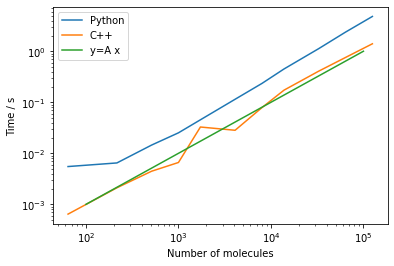

In [15]:
from matplotlib import pyplot as plt


time_genice_icerule = np.array(time_genice_icerule)
time_cpp_icerule = np.array(time_cpp_icerule)


fig1, ax = plt.subplots()

lin = np.linspace(1e2, 1e5, 100)
plt.loglog(time_genice_icerule[:, 0], time_genice_icerule[:, 1], label="Python")
plt.loglog(time_cpp_icerule[:, 0], time_cpp_icerule[:, 1], label="C++")

plt.loglog(lin, lin*1e-5, label=r"y=A x")
plt.legend()
plt.xlabel("Number of molecules")
plt.ylabel("Time / s")

fig1.savefig("benchmark-cp-loglog.pdf")

# C++ is four times faster than python,
# but Python is fast enough...

# TOC Graphics

128


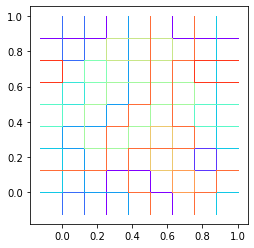

In [4]:
# for TOC graphics

from matplotlib import pyplot as plt
import tilecycles as tc



N = 8
X = np.arange(N)
Y = np.arange(N)
X, Y = np.meshgrid(X, Y)
X = X.reshape(N * N)
Y = Y.reshape(N * N)
pos = np.vstack([X, Y]).T / N  # fractional coordinate
g = nx.Graph()
for a in range(N*N):
    for b in range(a):
        d = pos[a] - pos[b]
        d -= np.floor(d+0.5)
        if (d@d)*N*N < 1.1:
            g.add_edge(a, b)

print(g.number_of_edges())


fig1, ax = plt.subplots()

cycles = []
dd = nx.DiGraph()
for cycle in tc.tileByCycles(g):
    cycles.append(cycle)

threshold = 1.1/N**2
cm = plt.get_cmap('rainbow')
for i, cycle in enumerate(cycles):
    draw_cycle(cycle, pos, threshold, cm(i/len(cycles)))

ax.set_aspect('equal', adjustable='box')
plt.show()
# fig1.savefig("map.pdf", bbox='tight')

In [ ]:
!pip install pycodestyle flake8 pycodestyle_magic

In [ ]:
%load_ext pycodestyle_magic